# MMMI Oversight Script


**TODO**: Proper scaling of subdivisions of a quarter

**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: Begin automated tests

**TODO**: Scale the 'Share' when asset levels adjust due to capital gains (currently the gains are being added to 'risk free' wealth proportional to share).

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)

import logging
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
sys.path.append('../PNL/py')

import util as UTIL
import pnl as pnl

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

In [4]:
risky_asset_price = 100

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [5]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [6]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [7]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [8]:
days_per_quarter = 10 # should be 60
quarters_per_simulation = 4

An attention rate: the chance on any day that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [9]:
attention_rate = 1.5 / days_per_quarter ## upping this to make more agents engaged in trade

We will need to convert daily price statistics to quarterly price statistics. HARK agents use quarterly (?) statistics. [**Question**: Should HARK agents rebalance knowing how many days are left in the quarter? Or based on a mean number of days between rebalancing periods (based on the attention rate)?]

In [10]:
import math

def ror_quarterly(ror, n_q):
    return pow(1 + ror, n_q) - 1

def sig_quarterly(std, n_q):
    """
     The second formula only holds for special cases (see the attached paper by Andrew Lo), 
     but since we are generating the data we meet this special case.
    """
    return math.sqrt(n_q) * std

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.

In [11]:
def lognormal_moments_to_normal(mu_x, std_x):
    mu = np.log(mu_x ** 2 / math.sqrt(mu_x ** 2 + std_x ** 2))
    
    sigma = math.sqrt(np.log(1 + std_x ** 2 / mu_x ** 2))

    return mu, sigma

def combine_lognormal_rates(ror1, std1, ror2, std2):
    mean1 = 1 + ror1
    mean2 = 1 + ror2
    
    mu1, sigma1 = lognormal_moments_to_normal(mean1, std1)
    mu2, sigma2 = lognormal_moments_to_normal(mean2, std2)
    
    mu3 = mu1 + mu2
    var3 = sigma1 **2 + sigma2 ** 2
    
    ror3 = exp(mu3 + var3 / 2) - 1
    sigma3 = math.sqrt((exp(var3) - 1) * exp(2 * mu3 + var3))
    
    return ror3, sigma3


### Data stores

For prices, rates or return, and standard deviations over time.

In [12]:
prices = [100]
ror_list = []
std_list = []

expected_ror_list = []
expected_std_list = []

buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Calculating risky expectations



A number of constants used in the calculation of risky expectations.

In [13]:
import math

p1 = 0.1
delta_t1 = 30

a = - math.log(p1) / delta_t1

p2 = 0.1
delta_t2 = 60

b = math.log(p2) / delta_t2

print(a)

print(b)

0.07675283643313485
-0.038376418216567426


In [14]:
def calculate_risky_expectations():
    # note use of data store lists for time tracking here -- not ideal
    D_t = sum([math.exp(a * (l + 1)) for l in range(len(ror_list))])
    S_t = math.exp(b * (len(prices) - 1)) # because p_0 is included in this list.
    
    w_0 = S_t
    w_t = [(1 - S_t) * math.exp(a * (t+1)) / D_t for t in range(len(ror_list))]
    
    print(f"D_t: {D_t}\nS_t / w_0  : {S_t}") # "\nror_list: {ror_list}\n w_t: {w_t}")
    
    expected_ror = w_0 * sp500_ror + sum(
        [w_ror[0] * w_ror[1]
         for w_ror
         in zip(w_t, ror_list)])
    expected_ror_list.append(expected_ror)
    
    expected_std = math.sqrt(
        w_0 * pow(sp500_std, 2) \
        +  sum([w_ror_er[0] * pow(w_ror_er[1] - expected_ror, 2)
                for w_ror_er
                in zip(w_t, ror_list)]))
    expected_std_list.append(expected_std)
    
    print(f'daily expectations: {expected_ror},{expected_std}')

    # expected capital gains quarterly
    ex_cg_q_ror = ror_quarterly(expected_ror, days_per_quarter)
    ex_cg_q_std = sig_quarterly(expected_std, days_per_quarter)
    
    
    # factor in dividend:
    cg_w_div_ror, cg_w_div_std = combine_lognormal_rates(
        ex_cg_q_ror,
        ex_cg_q_std,
        dividend_ror,
        dividend_std

    )
     
    market_risky_params = {
        'RiskyAvg': 1 + cg_w_div_ror,
        'RiskyStd': cg_w_div_std
    }
    
    return market_risky_params


### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [15]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 3, #3, 
        'AgentCount' : 10,
        'aNrmInitMean': 2
    }] * 10 + \
    [{
        'CRRA': 5, #5, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 2, #2, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10


### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
}

agent_parameters.update(calculate_risky_expectations())

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


Realistic income shock standard deviations from Sabelhaus and Song:

In [16]:
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

agent_parameters['TranShkStd'] = [ssvp['TranShkStd'][idx_40] / 2]  # Adjust non-multiplicative shock to quarterly
agent_parameters['PermShkStd'] = [ssvp['PermShkStd'][idx_40] ** 0.25]

In [17]:
len(agent_classes)

50

Initialize the agents.

In [18]:
# This is handling this distribution of discount factors based on cstw_MPC in a hacky way
#      This should be corrected with some HARK updates.
#
#
agents = hpa.create_agents(agent_classes, agent_parameters)

/home/sb/projects/econ-ark/HARK/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


In [19]:
agents[0]

<HARK.ConsumptionSaving.ConsPortfolioModel.PortfolioConsumerType object at 0x7f6035d07850.
Parameters:
CRRA: 2
Rfree: 1.0
DiscFac: 0.9402000000000001
LivPrb: [0.9949620563926881]
PermGroFac: [1.0024906793143211]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 2
aNrmInitMean: 2
aNrmInitStd: 0.0
pLvlInitMean: 1.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: None
T_cycle: 1
aXtraMin: 0.001
aXtraMax: 100
aXtraNestFac: 1
aXtraCount: 200
aXtraExtra: [None]
PermShkStd: [0.6191893521335157]
PermShkCount: 7
TranShkStd: [0.1658834945210779]
TranShkCount: 7
UnempPrb: 0.05
UnempPrbRet: 0.005
IncUnemp: 0.3
IncUnempRet: 0.0
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
RiskyAvg: 1.0364867103444708
RiskyStd: 0.04032430246695317
RiskyCount: 5
ShareCount: 25
AdjustPrb: 1.0
DiscreteShareBool: False>

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [20]:
def compute_share_demand(agent):
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']
    
    #print("Market Resources: " + str(market_resources))

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
    
    #print("Risky Share: " + str(risky_share))
    #print("Risky Asset Wealth: " + str(risky_asset_wealth))
    
    shares = risky_asset_wealth / risky_asset_price
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    #print("Shares: " + str(shares))
    
    return shares

In [21]:
#for agent in agents:
#    agent.shares = compute_share_demand(agent)

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

In [22]:
import random

def activate(agents, attention_rate):
    for agent in agents:
        agent.attentive = random.random() < attention_rate

In [23]:
activate(agents, attention_rate)

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [24]:
def compute_total_buy_sell(agents):
    """
    TODO: Should this be done without making so many changes to the underlying
    agent? Could be done using copies.
    """
    risky_expectations = calculate_risky_expectations()
    
    print(risky_expectations)
    
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if agent.attentive:
            # Note: this mutates the underlying agent
            agent.assign_parameters(**risky_expectations)
            
            d_shares = compute_share_demand(agent)
            
            delta_shares = d_shares - agent.shares
            
            # NOTE: This mutates the agent
            agent.shares = d_shares
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    return (round(buy_shares_total), round(sell_shares_total))

In [25]:
#compute_total_buy_sell(agents)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

In [26]:
import os

def run_market(config, buy_sell, seed = None):    
    pnl.run_NLsims(
        config,
        broker_buy_limit = buy_sell[0],
        broker_sell_limit = buy_sell[1],
        SEED = seed,
        use_cache = True
    )

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [27]:
def get_transactions(config, seed = 0, buy_sell = (0,0)):
    logfile = pnl.transaction_file_name(config, seed, buy_sell[0], buy_sell[1])
    
    # use run_market() first to create logs
    transactions = pd.read_csv(
        logfile,
        delimiter='\t'
    )
    return transactions

def get_last_simulation_price(config, seed = 0, buy_sell = (0,0)):
    """
    Dividing the output of this by 4
    """
    
    transactions = get_transactions(config, seed=seed, buy_sell = buy_sell)
    prices = transactions['TrdPrice']
    
    if len(prices.index) == 0:
        ## BUG FIX HACK
        print("ERROR in PNL script: zero transactions. Reporting no change")
        return None
    
    return prices[prices.index.values[-1]]

In [28]:
netlogo_ror = -0.00052125
netlogo_std =  0.0068
simulation_price_scale = 0.25

def daily_rate_of_return(config = None, seed = 0, buy_sell = (0, 0)):
    
    last_sim_price = get_last_simulation_price(config, seed=seed, buy_sell = buy_sell)
    
    if last_sim_price is None:
        last_sim_price = 400
    
    ror = (last_sim_price * simulation_price_scale - 100) / 100
    
    # adjust to calibrated NetLogo to S&P500
    ror = sp500_std * (ror - netlogo_ror) / netlogo_std + sp500_ror
    
    return ror

In [29]:
def update_agent_wealth(old_share_price, ror):

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        market_resources = agent.state_now['mNrm'] * agent.state_now['pLvl']
    
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_mNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_mNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print("ERROR: Agent has NaN aNrm after wealth update from share prices. Setting to 0.")
            agent.state_now['aNrm'][:] = 0.0
        
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

## Run the main loop



In [30]:
import itertools

seeds = itertools.cycle([0,6,3,2,5,1,4])

config = UTIL.read_config(
    config_file = "../PNL/macroliquidity.ini",
    config_local_file = "../PNL/macroliquidity_local.ini"
)

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")

    agent_id = 0
    
    for agent in agents:
        agent_id = agent_id + 1
        #agent.assign_parameters(AdjustPrb = 0.0)
        agent.solve()
        
        ## For risky asset gains in the simulated quarter,
        ## use only the dividend.
        true_risky_expectations = {
            "RiskyAvg" : agent.parameters['RiskyAvg'],
            "RiskyStd" : agent.parameters['RiskyStd']   
        }
        
        dividend_risky_params = {
            "RiskyAvg" : 1 + dividend_ror,
            "RiskyStd" : dividend_std
        }
        
        agent.assign_parameters(**dividend_risky_params)
        
        agent.simulate(sim_periods=1)
        
        ## put back the expectations that include capital gains now
        agent.assign_parameters(**true_risky_expectations)
     
    if quarter == 0:
        for agent in agents:
            agent.shares = compute_share_demand(agent)
            
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum() for agent in agents]) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        total_asset_levels_list.append(total_asset_levels)

    for day in range(days_per_quarter):
        print(f"Q-{quarter}:D-{day}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        activate(agents, attention_rate)
        buy_sell = compute_total_buy_sell(agents)
        print("Buy/Sell Limit: " + str(buy_sell))
        buy_sell_list.append(buy_sell)
        
        run_market(config, buy_sell, seed = seed)
        
        ror =  daily_rate_of_return(config = config, seed = seed, buy_sell = buy_sell)
        print("ror: " + str(ror))
        ror_list.append(ror)
        
        update_agent_wealth(risky_asset_price, ror)
        
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned Shares: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum()
                                  for agent
                                  in agents]
                                ) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
        total_consumption_levels = sum([
            (agent.controls['cNrm'] * agent.state_now['pLvl']).sum() for agent in agents
        ])
        #print("Total Consumption Levels: " + str(total_consumption_levels))
        
        total_asset_levels_list.append(total_asset_levels)
        
        risky_asset_price = risky_asset_price * (1 + ror)
        prices.append(risky_asset_price)
        
        print(f"Price end of day {day}: {risky_asset_price}")
        print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Owned: 7095.576794347009
Total Asset Levels: 709557.6794347006
Q-0:D-0
D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988
{'RiskyAvg': 1.0364867103444708, 'RiskyStd': 0.04032430246695317}
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7095.576794347009
Total Asset Levels: 713782.5888124206
Tot. Owned Share V: 709557.6794347009
Price end of day 0: 100.59542860294117

Q-0:D-1
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0008285313326319651,0.011802145880789828
{'RiskyAvg': 1.0385657607407528, 'RiskyStd': 0.039743476689578026}
Buy/Sell Limit: (0, 0)
Output for S:6,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7095.576794347009
Total Asset Levels: 718032.6545090232
Tot. Owned Share V: 713782.5888124207
Price end of day 1: 101.19440255809435

Q-0:D

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (696, 327)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL696SL327.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks

Elapsed (sys clock), run 2:  45.209296139
ror: 0.01476899191176471
Owned Shares: 7464.984337429345
Total Asset Levels: 1031674.8434504535
Tot. Owned Share V: 778365.5294630049
Price end of day 0: 105.80882262695255

Q-1:D-1
D_t: 17.951844000001877
S_t / w_0  : 0.6556418494179789
daily expectations: 0.0023088356221044677,0.010176381717308558
{'RiskyAvg': 1.0540296132719185, 'RiskyStd': 0.03469118987353831}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (596, 311)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL596SL311.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 5:  29.637337032999994
ror: 0.019176344852941174
Owned Shares: 7750.477102144808
Total Asset Levels: 1047400.7666549684
Tot. Owned Share V: 820068.8569750971
Price end of day 1: 107.83784909813068

Q-1:D-2
D_t: 20.463730431511458
S_t / w_0  : 0.6309573444801932
daily expectations: 0.0030484408233457643,0.010482355211860148
{'RiskyAvg': 1.0618331908634624, 'RiskyStd': 0.035666526159902345}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (512, 258)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL512SL258.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  25.43965141999999
ror: 0.0015469330882352942
Owned Shares: 8004.3429177359185
Total Asset Levels: 1048736.0346270152
Tot. Owned Share V: 863171.123692497
Price end of day 2: 108.00466703506471

Q-1:D-3
D_t: 23.176003010843488
S_t / w_0  : 0.6072021956909885
daily expectations: 0.0029449899492646966,0.010281073509707073
{'RiskyAvg': 1.0607385617362366, 'RiskyStd': 0.03503626304497078}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (314, 159)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL314SL159.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 4:  25.257026888000013
ror: 0.010361638970588236
Owned Shares: 8159.308436241479
Total Asset Levels: 1057867.1604886625
Tot. Owned Share V: 881243.3908926555
Price end of day 3: 109.12377240202065

Q-1:D-4
D_t: 26.104647575468725
S_t / w_0  : 0.5843414133735176
daily expectations: 0.003258670747683123,0.0101419452813654
{'RiskyAvg': 1.0640607978328993, 'RiskyStd': 0.034612969609349}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (428, 216)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL428SL216.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  26.411096490999967
ror: 0.005954286029411765
Owned Shares: 8371.814985494757
Total Asset Levels: 1063306.7820477386
Tot. Owned Share V: 913564.0330689556
Price end of day 4: 109.7735265555107

Q-1:D-5
D_t: 29.266925235637103
S_t / w_0  : 0.5623413251903491
daily expectations: 0.0033504941231569736,0.009930123538893349
{'RiskyAvg': 1.065035082014932, 'RiskyStd': 0.0339579541307948}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (315, 136)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL315SL136.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 6:  29.852793323000014
ror: 0.019176344852941174
Owned Shares: 8550.422396685119
Total Asset Levels: 1081305.8914741315
Tot. Owned Share V: 938610.0200233473
Price end of day 5: 111.87858155646266

Q-1:D-6
D_t: 32.681474109470706
S_t / w_0  : 0.5411695265464637
daily expectations: 0.0040731686747569815,0.010175890508598675
{'RiskyAvg': 1.0727310287494551, 'RiskyStd': 0.03474365570953418}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (368, 161)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL368SL161.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 3:  23.599643039
ror: 0.01476899191176471
Owned Shares: 8757.717913547613
Total Asset Levels: 1095776.5653724982
Tot. Owned Share V: 979801.0578393306
Price end of day 6: 113.53091542256976

Q-1:D-7
D_t: 36.36841917399028
S_t / w_0  : 0.5207948328595463
daily expectations: 0.00454836067448168,0.010126458206593589
{'RiskyAvg': 1.0778187076744516, 'RiskyStd': 0.03460498267294619}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (366, 174)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL366SL174.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 2:  25.492111070999954
ror: 0.010361638970588236
Owned Shares: 8949.304892188693
Total Asset Levels: 1106304.2265716554
Tot. Owned Share V: 1016022.7768058643
Price end of day 7: 114.70728178017882

Q-1:D-8
D_t: 40.349490879525256
S_t / w_0  : 0.5011872336272722
daily expectations: 0.0047851849624898505,0.009932984445161691
{'RiskyAvg': 1.0803623842446965, 'RiskyStd': 0.03401242612020878}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (153, 70)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL153SL70.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 5:  24.43147386100003
ror: 0.019176344852941174
Owned Shares: 9031.922590788121
Total Asset Levels: 1126171.4431548186
Tot. Owned Share V: 1036027.2896382957
Price end of day 8: 116.90694817273902

Q-1:D-9
D_t: 44.64815322660753
S_t / w_0  : 0.4823178482239307
daily expectations: 0.00545153801351094,0.010064321110923986
{'RiskyAvg': 1.0875485469924933, 'RiskyStd': 0.03444095647434244}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (109, 55)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL109SL55.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 1:  22.86927569100004
ror: -0.0028604198529411764
Owned Shares: 9085.815106577491
Total Asset Levels: 1123133.1197300523
Tot. Owned Share V: 1062194.915771744
Price end of day 9: 116.57254521723895

Q-2
Q-2:D-0
D_t: 49.28974206022031
S_t / w_0  : 0.4641588833612779
daily expectations: 0.004974546917599143,0.010098252603643049
{'RiskyAvg': 1.0824001642745555, 'RiskyStd': 0.03453093152423292}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (166, 504)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL166SL504.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 4:  23.36376150999996
ror: -0.007267772794117647
Owned Shares: 8748.05925326264
Total Asset Levels: 738077.5531685327
Tot. Owned Share V: 1019783.5328640447
Price end of day 0: 115.72532244456806

Q-2:D-1
D_t: 54.30161439649304
S_t / w_0  : 0.44668359215096315
daily expectations: 0.004298811332144012,0.010337767792469277
{'RiskyAvg': 1.0751441876388634, 'RiskyStd': 0.0352539749815974}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (220, 634)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL220SL634.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  25.447487982999974
ror: -0.016082478676470592
Owned Shares: 8334.024687602934
Total Asset Levels: 722566.682866659
Tot. Owned Share V: 964457.6942338402
Price end of day 1: 113.86417241402562

Q-2:D-2
D_t: 59.71330966195767
S_t / w_0  : 0.4298662347082277
daily expectations: 0.003204160158014034,0.011178969682345037
{'RiskyAvg': 1.0634827973271932, 'RiskyStd': 0.037848806208005396}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (203, 579)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL203SL579.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 6:  23.504875963000018
ror: -0.011675125735294117
Owned Shares: 7958.289396600677
Total Asset Levels: 711987.1038098464
Tot. Owned Share V: 906164.0359752513
Price end of day 2: 112.53479388434666

Q-2:D-3
D_t: 65.55672379569285
S_t / w_0  : 0.4136820402388507
daily expectations: 0.0023981628455702394,0.011446163780683713
{'RiskyAvg': 1.0549693566362843, 'RiskyStd': 0.03866487793136659}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (140, 409)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL140SL409.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 3:  22.745236911999996
ror: -0.016082478676470592
Owned Shares: 7688.814013970978
Total Asset Levels: 698071.5927800144
Tot. Owned Share V: 865259.1002773
Price end of day 3: 110.72495546134063

Q-2:D-4
D_t: 71.86629724049477
S_t / w_0  : 0.39810717055349726
daily expectations: 0.0014025987069429418,0.011928657894787385
{'RiskyAvg': 1.0445382921438155, 'RiskyStd': 0.04015682183939941}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (114, 297)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL114SL297.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 2:  21.929075667999996
ror: -0.011675125735294117
Owned Shares: 7506.794504571108
Total Asset Levels: 688367.3510073789
Tot. Owned Share V: 831189.4871760724
Price end of day 4: 109.43222768429463

Q-2:D-5
D_t: 78.67921793107439
S_t / w_0  : 0.38311868495572876
daily expectations: 0.0006959551805252088,0.011982124444632009
{'RiskyAvg': 1.0371908298642998, 'RiskyStd': 0.040307477103810274}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (102, 303)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL102SL303.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 5:  24.129533379999998
ror: -0.011675125735294117
Owned Shares: 7305.070423290661
Total Asset Levels: 679034.1372277635
Tot. Owned Share V: 799410.1298113501
Price end of day 5: 108.15459266658715

Q-2:D-6
D_t: 86.0356404756708
S_t / w_0  : 0.36869450645195756
daily expectations: 2.7482791693476353e-05,0.011979396215257374
{'RiskyAvg': 1.0302831077653423, 'RiskyStd': 0.040282166479771335}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (70, 215)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL70SL215.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 1:  24.05975166600001
ror: -0.011675125735294117
Owned Shares: 7160.110551094096
Total Asset Levels: 669992.9334003153
Tot. Owned Share V: 774398.8401013148
Price end of day 6: 106.89187419835523

Q-2:D-7
D_t: 93.97892282291362
S_t / w_0  : 0.35481338923357547
daily expectations: -0.0006047678184300283,0.011930612285040092
{'RiskyAvg': 1.0237878163996608, 'RiskyStd': 0.040112586355188676}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (95, 259)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL95SL259.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 4:  22.703958473000057
ror: 0.0015469330882352942
Owned Shares: 6995.871512414436
Total Asset Levels: 671149.7327754229
Tot. Owned Share V: 747801.817612861
Price end of day 7: 107.05722877541615

Q-2:D-8
D_t: 102.55588180882256
S_t / w_0  : 0.3414548873833602
daily expectations: -0.0004744478761010895,0.011612715722927153
{'RiskyAvg': 1.025123607108291, 'RiskyStd': 0.03911353583056557}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (37, 83)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL37SL83.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 0:  24.370546196999953
ror: 0.005954286029411765
Owned Shares: 6949.811252269919
Total Asset Levels: 675579.8855217348
Tot. Owned Share V: 744027.5331802221
Price end of day 8: 107.69467813706115

Q-2:D-9
D_t: 111.8170690901105
S_t / w_0  : 0.3285993247600655
daily expectations: -0.0001066906245236758,0.011394013454159642
{'RiskyAvg': 1.02890161401425, 'RiskyStd': 0.03843454984522861}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (58, 155)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL58SL155.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 6:  23.101641006000023
ror: -0.007267772794117647
Owned Shares: 6853.015167157567
Total Asset Levels: 670216.0274539638
Tot. Owned Share V: 738033.2626954324
Price end of day 9: 106.91197768522537

Q-3
Q-3:D-0
D_t: 121.8170690901105
S_t / w_0  : 0.316227766016838
daily expectations: -0.0005020042694211593,0.01118709622875326
{'RiskyAvg': 1.0248410209862295, 'RiskyStd': 0.03777372327399357}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (26, 302)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL26SL302.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  20.330761112999994
ror: -0.016082478676470592
Owned Shares: 6576.579700934006
Total Asset Levels: 514340.9965104231
Tot. Owned Share V: 703115.1422313625
Price end of day 0: 105.19256808384343

Q-3:D-1
D_t: 132.6148207133876
S_t / w_0  : 0.30432198871077215
daily expectations: -0.001374609511871323,0.011418499173083487
{'RiskyAvg': 1.015928782463909, 'RiskyStd': 0.03847909454471048}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (41, 317)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL41SL317.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 2:  21.922820253000054
ror: -0.007267772794117647
Owned Shares: 6300.524496624936
Total Asset Levels: 509524.1467124095
Tot. Owned Share V: 662768.3520751419
Price end of day 1: 104.4280523993803

Q-3:D-2
D_t: 144.2739647251859
S_t / w_0  : 0.2928644564625237
daily expectations: -0.0016942975479951278,0.011158968202024923
{'RiskyAvg': 1.01268119023581, 'RiskyStd': 0.03765434740506861}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (37, 314)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL37SL314.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 5:  22.300548290999927
ror: -0.007267772794117647
Owned Shares: 6023.6410623692855
Total Asset Levels: 504952.447957862
Tot. Owned Share V: 629037.1044961585
Price end of day 2: 103.66909304120941

Q-3:D-3
D_t: 156.86321884312756
S_t / w_0  : 0.2818382931264454
daily expectations: -0.001996311819991192,0.010898736997108098
{'RiskyAvg': 1.009621725183355, 'RiskyStd': 0.03682884988539495}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (26, 268)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL26SL268.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 1:  22.212493088999963
ror: 0.0015469330882352942
Owned Shares: 5781.652694474862
Total Asset Levels: 505879.6466875313
Tot. Owned Share V: 599378.6911154735
Price end of day 3: 103.82946219146221

Q-3:D-4
D_t: 170.4567827519128
S_t / w_0  : 0.27122725793320285
daily expectations: -0.0017693046549442958,0.010633278688520187
{'RiskyAvg': 1.011920575431785, 'RiskyStd': 0.03600218096969326}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (11, 180)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL11SL180.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 4:  20.554276007999988
ror: 0.019176344852941174
Owned Shares: 5612.874859557109
Total Asset Levels: 517055.2710367729
Tot. Owned Share V: 582781.7780157937
Price end of day 4: 105.82053176434111

Q-3:D-5
D_t: 185.1347754281335
S_t / w_0  : 0.2610157215682537
daily expectations: -0.0005234441158769881,0.011488555358525535
{'RiskyAvg': 1.0246212075058945, 'RiskyStd': 0.038721303634727075}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (22, 163)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL22SL163.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 0:  21.87611619400002
ror: -0.0028604198529411764
Owned Shares: 5471.1785298795985
Total Asset Levels: 515399.19371621404
Tot. Owned Share V: 578963.0214095052
Price end of day 5: 105.5178406144336

Q-3:D-6
D_t: 200.98370735274466
S_t / w_0  : 0.251188643150958
daily expectations: -0.0006527367083247468,0.011158343910264441
{'RiskyAvg': 1.023296525691793, 'RiskyStd': 0.03767942738528879}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (14, 69)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL14SL69.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 6:  21.17557592600008
ror: -0.016082478676470592
Owned Shares: 5415.3872222827895
Total Asset Levels: 506209.34430114686
Tot. Owned Share V: 571419.9657862757
Price end of day 6: 103.82085219276475

Q-3:D-7
D_t: 218.09699039436248
S_t / w_0  : 0.2417315480804104
daily expectations: -0.0015613976223807727,0.011393798924789355
{'RiskyAvg': 1.0140301348368599, 'RiskyStd': 0.0383966015845279}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (7, 44)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL7SL44.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 571

Elapsed (sys clock), run 3:  26.10959686199999
ror: -0.011675125735294117
Owned Shares: 5378.818386214421
Total Asset Levels: 499689.56287289254
Tot. Owned Share V: 558433.5086468927
Price end of day 7: 102.60873068946883

Q-3:D-8
D_t: 236.57548836858538
S_t / w_0  : 0.23263050671536264
daily expectations: -0.0021520364941877913,0.011279873949432195
{'RiskyAvg': 1.0080474558108805, 'RiskyStd': 0.038023046269315096}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (28, 140)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL28SL140.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 2:  25.136251854999955
ror: -0.011675125735294117
Owned Shares: 5267.272740698171
Total Asset Levels: 493379.5290308374
Tot. Owned Share V: 540468.170118279
Price end of day 8: 101.41076085713034

Q-3:D-9
D_t: 256.52811151827416
S_t / w_0  : 0.22387211385683395
daily expectations: -0.002707769399027731,0.01113881130313807
{'RiskyAvg': 1.0024473717999995, 'RiskyStd': 0.037565107560241374}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (3, 68)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL3SL68.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 571

Elapsed (sys clock), run 5:  26.825525125000013
ror: 0.01476899191176471
Owned Shares: 5201.656653205811
Total Asset Levels: 501170.230733538
Tot. Owned Share V: 527503.9589191555
Price end of day 9: 102.90849556399519



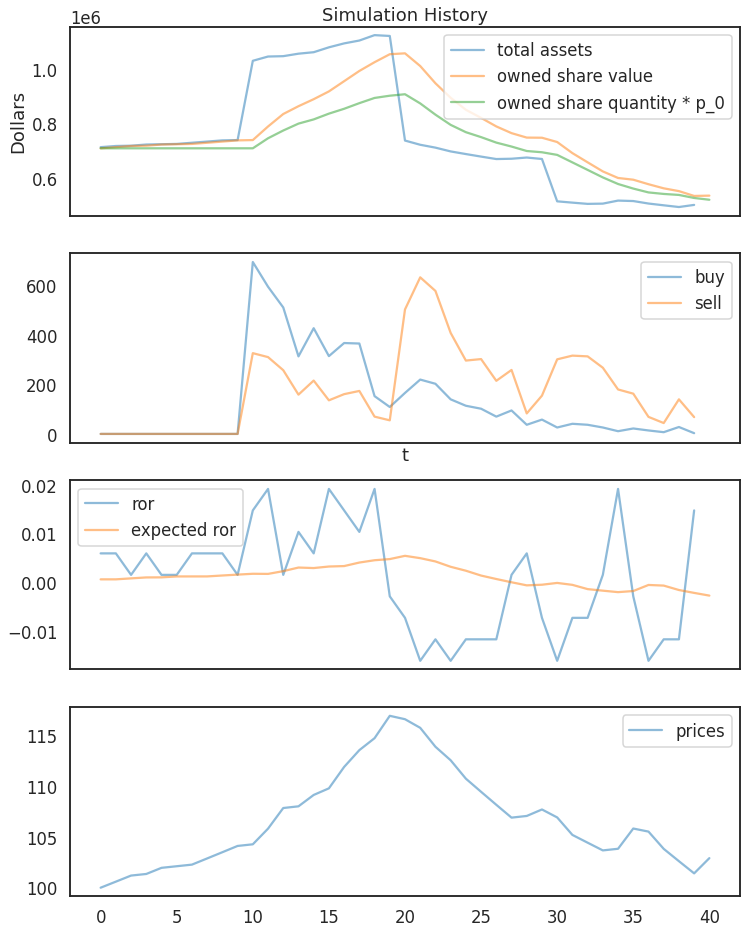

In [31]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(total_asset_levels_list[1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(prices, owned_shares_list)], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(prices, owned_shares_list)], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in buy_sell_list], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in buy_sell_list], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(ror_list, alpha=0.5, label='ror')
ax[2].plot(expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

In [32]:
data = pd.DataFrame.from_dict({
    't' : range(len(prices)),
    'prices' : prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + ror_list,
    'expected_ror' : expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,7095.576794,7.095577e+05,NaN,0.000628,0.011988
1,1,100.595429,0.0,0.0,7095.576794,7.137826e+05,0.005954,0.000628,0.011988
2,2,101.194403,0.0,0.0,7095.576794,7.180327e+05,0.005954,0.000829,0.011802
3,3,101.350944,0.0,0.0,7095.576794,7.191434e+05,0.001547,0.001022,0.011614
4,4,101.954416,0.0,0.0,7095.576794,7.234254e+05,0.005954,0.001035,0.011392
5,5,102.112133,0.0,0.0,7095.576794,7.245445e+05,0.001547,0.001224,0.011208
6,6,102.270093,0.0,0.0,7095.576794,7.256653e+05,0.001547,0.001227,0.010993
7,7,102.879039,0.0,0.0,7095.576794,7.299861e+05,0.005954,0.001230,0.010782
8,8,103.491610,0.0,0.0,7095.576794,7.343327e+05,0.005954,0.001418,0.010608
9,9,104.107829,0.0,0.0,7095.576794,7.387051e+05,0.005954,0.001598,0.010433


In [33]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,0.141891,-0.197779,0.347219,-0.508750,-0.513134,-0.408301,-0.498327,0.146235
prices,0.141891,1.000000,0.493728,0.510809,0.760313,0.605852,0.051440,0.758927,-0.560593
buy,-0.197779,0.493728,1.000000,0.417477,0.561480,0.742892,0.361079,0.536954,-0.576739
sell,0.347219,0.510809,0.417477,1.000000,0.230794,-0.024148,-0.404079,0.209202,-0.083308
owned,-0.508750,0.760313,0.561480,0.230794,1.000000,0.863989,0.247285,0.952496,-0.529148
total_assets,-0.513134,0.605852,0.742892,-0.024148,0.863989,1.000000,0.547678,0.834509,-0.665288
ror,-0.408301,0.051440,0.361079,-0.404079,0.247285,0.547678,1.000000,0.196290,-0.498882
expected_ror,-0.498327,0.758927,0.536954,0.209202,0.952496,0.834509,0.196290,1.000000,-0.625212
expected_std,0.146235,-0.560593,-0.576739,-0.083308,-0.529148,-0.665288,-0.498882,-0.625212,1.000000


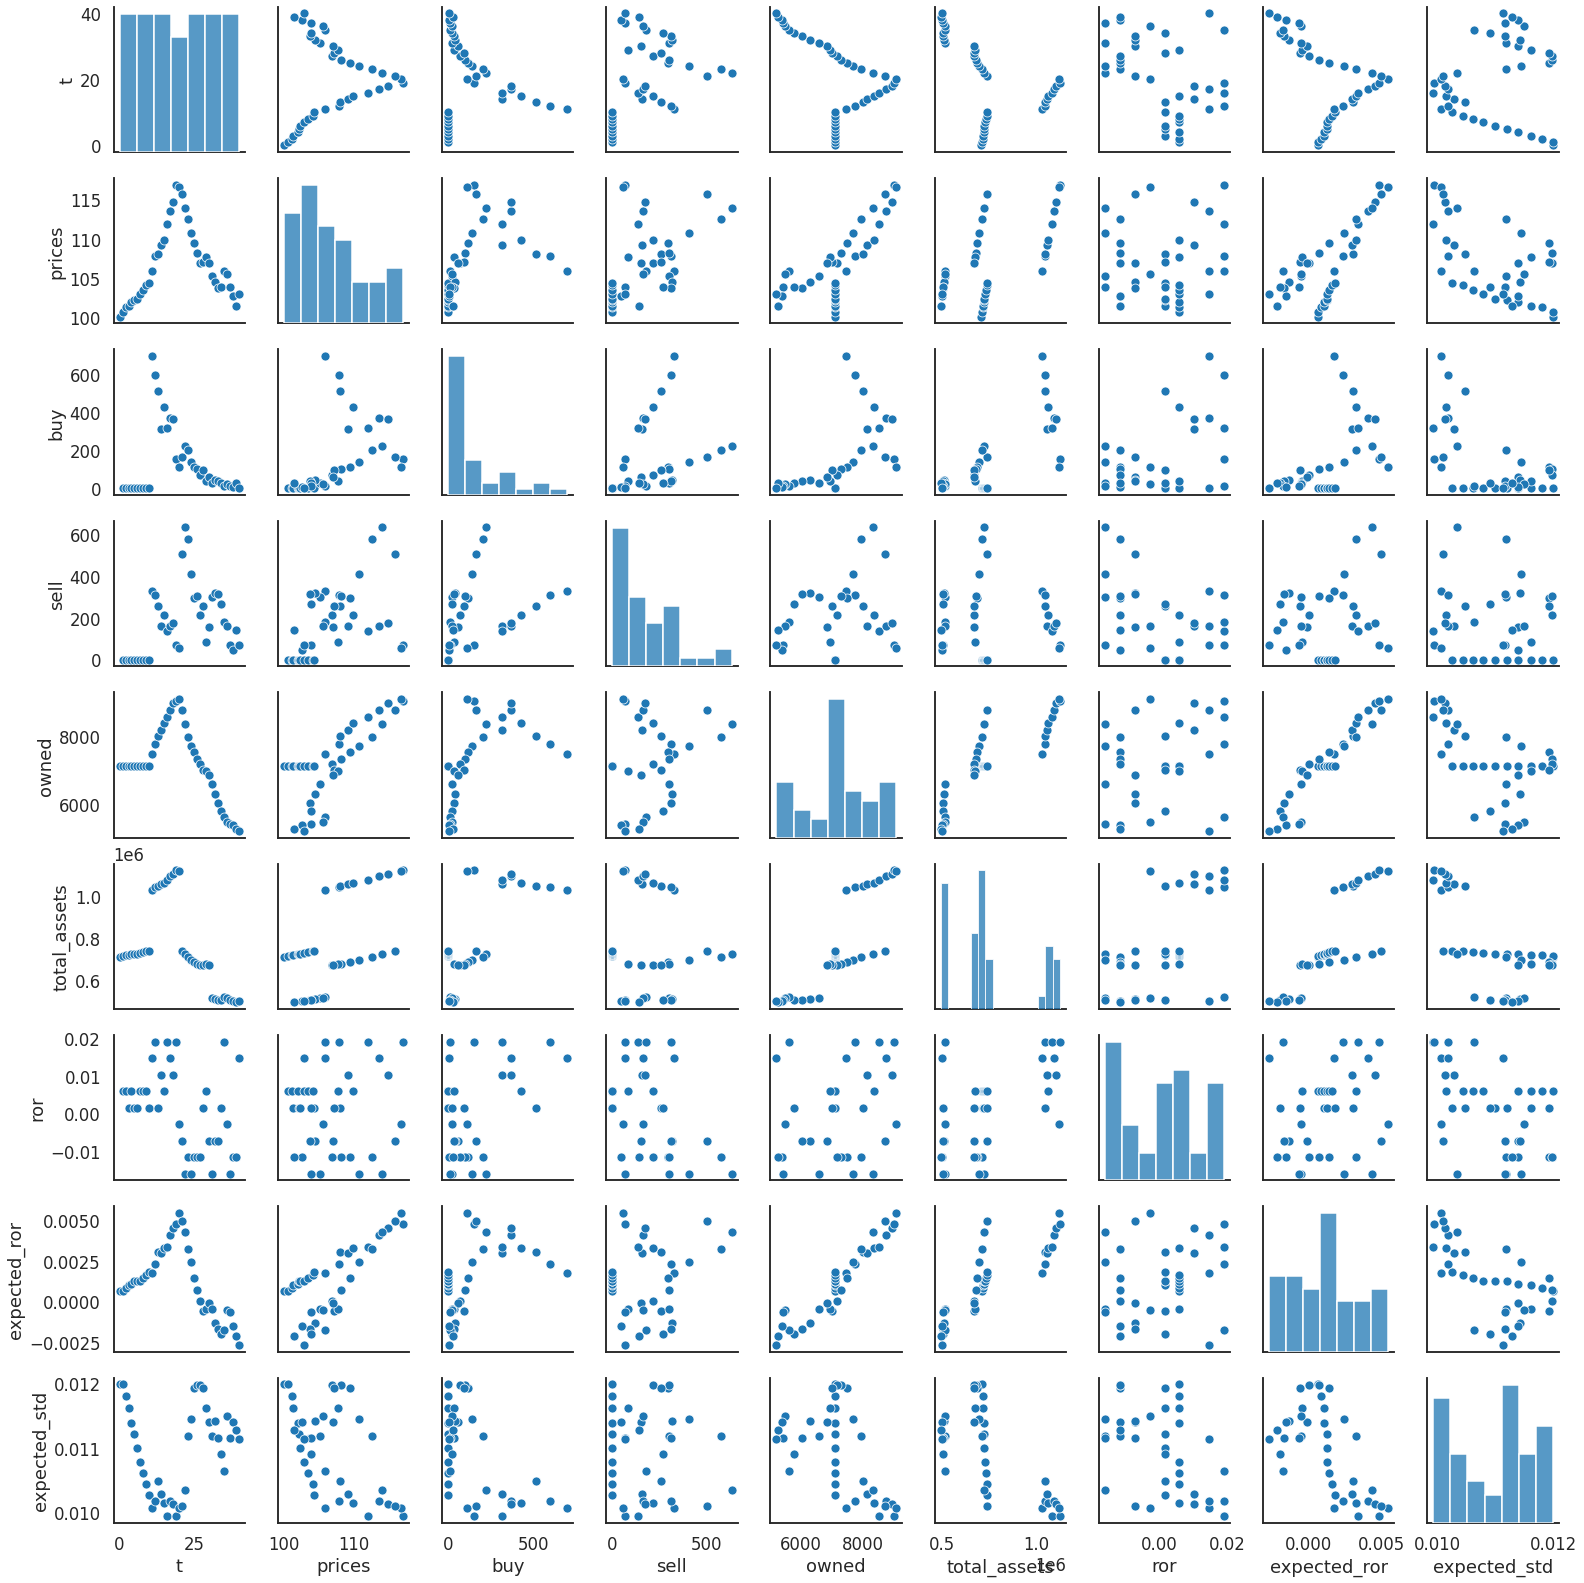

In [34]:
import seaborn as sns

sns.pairplot(data)

In [35]:
data['sell'].max()

634.0

In [36]:
500 / 348


1.4367816091954022

<AxesSubplot:xlabel='t', ylabel='total_assets'>

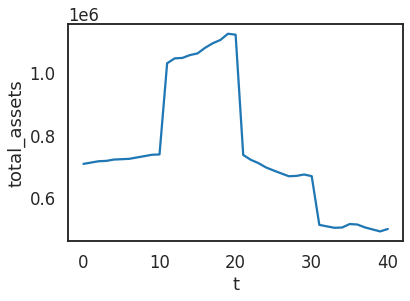

In [37]:
sns.lineplot(data= data, x = 't', y='total_assets')

<AxesSubplot:xlabel='t', ylabel='expected_ror'>

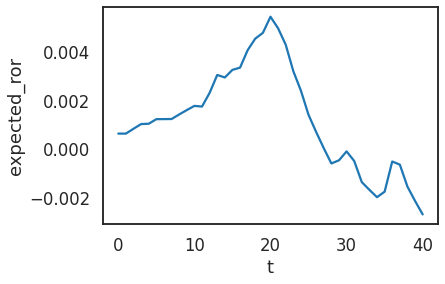

In [38]:
sns.lineplot(data= data, x = 't', y='expected_ror')

<AxesSubplot:xlabel='t', ylabel='expected_std'>

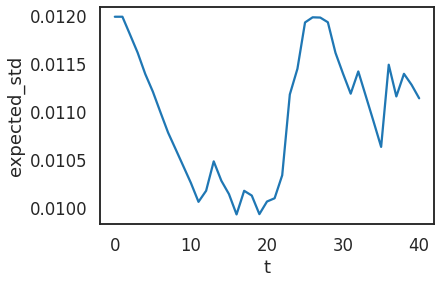

In [39]:
sns.lineplot(data= data, x = 't', y='expected_std')